## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(1, 2):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.74it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_1"])
layer_hs_array.shape

(10000, 267264)

## Layer 1 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 10
  Iteration 19 (0.55 s, search 0.29 s): objective=1747.19 imbalance=1.041 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.07 s, search 0.56 s): objective=1753.16 imbalance=1.080 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (1.61 s, search 0.83 s): objective=1749.3 imbalance=1.032 nsplit=0        
Outer iteration 3 / 10
  Iteration 19 (2.15 s, search 1.12 s): objective=1752.98 imbalance=1.070 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (2.70 s, search 1.40 s): objective=1753.45 imbalance=1.089 nsplit=0       
Objective improved: keep new clusters
Outer iteration 5 / 10
  Iteration 19 (3.24 s, search 1.68 s): objective=1752.98 imbalance=1.071 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (3.78 s, search 1.97 s

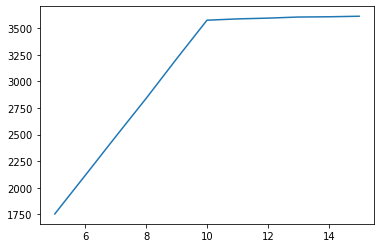

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 10
  Iteration 19 (1.09 s, search 0.55 s): objective=3563.99 imbalance=1.100 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.18 s, search 1.10 s): objective=3574.33 imbalance=1.098 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.30 s, search 1.67 s): objective=3573.01 imbalance=1.069 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (4.38 s, search 2.21 s): objective=3568.81 imbalance=1.032 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (5.45 s, search 2.76 s): objective=3550.42 imbalance=1.329 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (6.55 s, search 3.32 s): objective=3564.99 imbalance=1.091 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (7.65 s, search 3.87 s): objective=3571.56 imbalance=1.087 nsplit=0       
Outer iteration 7 / 10
  Iter

3574.3251953125

In [15]:
kmeans.centroids #cluster centers

array([[ 0.00788479, -0.00245186,  0.00508965, ...,  0.0005908 ,
         0.00694053,  0.02149335],
       [ 0.01280584, -0.00535829,  0.0045237 , ..., -0.003448  ,
         0.01033644,  0.01997647],
       [ 0.01582413, -0.00206316,  0.01063342, ..., -0.00043358,
         0.0047822 ,  0.0176275 ],
       ...,
       [ 0.00752247, -0.00650674,  0.00617821, ..., -0.00041455,
         0.00455507,  0.01923003],
       [ 0.00879604, -0.00140388,  0.00779928, ..., -0.00254281,
         0.00647194,  0.02303556],
       [ 0.0135902 ,  0.00150788,  0.00603749, ..., -0.00048211,
         0.00830882,  0.01915834]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000001
0.9999999
0.9999999
1.0000002
0.99999994
0.99999994
1.0
1.0000004
1.0000001
0.9999997


In [17]:
kmeans.obj #inertia at each iteration

array([2116.89916992, 3435.32177734, 3507.75      , 3531.9152832 ,
       3541.11303711, 3546.59423828, 3550.03320312, 3552.94311523,
       3555.98291016, 3558.71582031, 3560.51416016, 3561.74584961,
       3562.41870117, 3562.86499023, 3563.16772461, 3563.44335938,
       3563.63598633, 3563.81079102, 3563.91113281, 3563.98779297,
       2231.78295898, 3426.10058594, 3475.55395508, 3501.41113281,
       3513.50439453, 3523.16674805, 3533.31787109, 3544.69067383,
       3553.94799805, 3559.890625  , 3563.8918457 , 3566.78857422,
       3569.39013672, 3571.95483398, 3572.99853516, 3573.47973633,
       3573.78588867, 3573.98583984, 3574.1550293 , 3574.32519531])

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

0    1139
5    1101
4    1007
6     978
7     887
8     752
1     699
3     601
9     479
2     357
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[2, 6, 10, 4, 5, 3, 5, 1, 9, 10]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 2, 1: 6, 2: 10, 3: 4, 4: 5, 5: 3, 6: 5, 7: 1, 8: 9, 9: 10}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 9,  9,  1, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.2375
Prompt 2 Accuracy:  0.30125
Prompt 3 Accuracy:  0.26375
Prompt 4 Accuracy:  0.1925
Prompt 5 Accuracy:  0.695
Prompt 6 Accuracy:  0.19375
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.15875
Prompt 10 Accuracy:  0.97875


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.302125


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

5    291
0    263
7    259
6    243
4    239
1    179
8    178
3    141
9    120
2     87
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 3,  9,  5, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.265
Prompt 2 Accuracy:  0.25
Prompt 3 Accuracy:  0.29
Prompt 4 Accuracy:  0.165
Prompt 5 Accuracy:  0.69
Prompt 6 Accuracy:  0.14
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.12
Prompt 10 Accuracy:  0.99


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.291


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

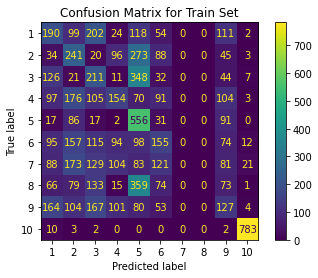

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

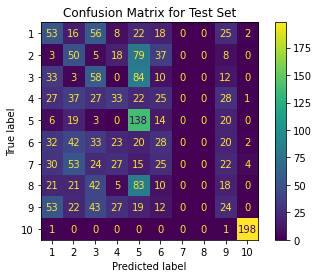

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()